In [1]:
import os
import pandas as pd
import datetime
import seaborn as sns
import holidays
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from scipy.stats import uniform, randint
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import xgboost as xgb
import lightgbm as lgb
import catboost
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LassoLarsCV, ElasticNetCV
import numpy as np
import problem
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# load train data
X, y = problem.get_train_data()

### Function to merge external data

In [7]:
def _merge_external_data(X, method='current_date'):
    external_data = pd.read_csv(os.path.join('submissions', 'test_20201117', 'external_data.csv'))
    
    # create a "year" and "month" columns to enable the merge
    X.loc[:, 'DateOfDeparture'] = pd.to_datetime(X.loc[:, 'DateOfDeparture'])
    external_data.loc[:, 'DateOfDeparture'] = pd.to_datetime(external_data.loc[:, 'DateOfDeparture'])

    X_merged = X.merge(external_data, how='left', on=['Departure', 'Arrival', 'DateOfDeparture'])
    X_merged.drop(columns=['gdp_capita_dep', 'population_dep', 
                           'gdp_capita_arr', 'population_arr'],
                  inplace=True)
    return X_merged

### Function to dummify data

In [8]:
def _dummify_data(X, col, new_col):
    to_dummify = dict(zip(col, new_col))
    
    for key in to_dummify.keys():
        column = X.loc[:, key]
        categories = list(column.dropna().unique())
        column = pd.Categorical(column, categories=categories)
        X.drop(key, axis=1, inplace=True)
        dummies = pd.get_dummies(column,
                                prefix=to_dummify[key])
        X = X.join(dummies)
        
    X = X.reindex(sorted(X.columns), axis=1)
        
    return X

### Function to encode dates

In [9]:
def _encode_dates(X):
    X_encoded = X.copy()

    # Make sure that DateOfDeparture is of datetime format
    X_encoded.loc[:, 'DateOfDeparture'] = pd.to_datetime(X_encoded.loc[:, 'DateOfDeparture'])
    
    # Encode the DateOfDeparture
    X_encoded.loc[:, 'day'] = X_encoded['DateOfDeparture'].dt.day
    X_encoded.loc[:, 'weekday'] = X_encoded['DateOfDeparture'].dt.weekday
    X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.week
    X_encoded.loc[:, 'is_weekend'] = [True if x in [5, 6] else False for x in X_encoded.loc[:, 'weekday']]
    
    # Encode holidays
    us_holidays = holidays.US()
    X_encoded.loc[:, 'is_holiday'] = [x in us_holidays for x in X_encoded['DateOfDeparture']]
    X_encoded.loc[:, 'is_beginning_holidays'] = [(x not in us_holidays) & (x + datetime.timedelta(days=1) in us_holidays) for x in X_encoded['DateOfDeparture']]
    X_encoded.loc[:, 'is_end_holidays'] = [(x in us_holidays) & (x + datetime.timedelta(days=1) not in us_holidays) for x in X_encoded['DateOfDeparture']]
    
    #X_encoded.drop(columns=['DateOfDeparture'], inplace=True)

    return X_encoded 

### Create the dataset

In [10]:
X = _merge_external_data(X)
X = _encode_dates(X)
print(X.shape)

(8902, 26)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


In [11]:
X.head(2)

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,event_level_dep,mean_temp_dep,year,month,departures_performed,...,sum_pop_dep_arr,avg_monthly_cost_gallon,perc_cancelled,day,weekday,week,is_weekend,is_holiday,is_beginning_holidays,is_end_holidays
0,2012-06-19,ORD,DFW,12.875000,9.812647,0.0,31,2012,6,742.0,...,3961256,0.339082,0.0,19,1,25,False,False,False,False
1,2012-09-10,LAS,DEN,14.285714,9.466734,0.0,32,2012,9,649.0,...,1228438,0.294737,0.0,10,0,37,False,False,False,False


### Exploratory data analysis

Our goal in this section is to understand which variables are correlated with the target log_PAX. 

In [12]:
X['log_PAX'] = y

<AxesSubplot:>

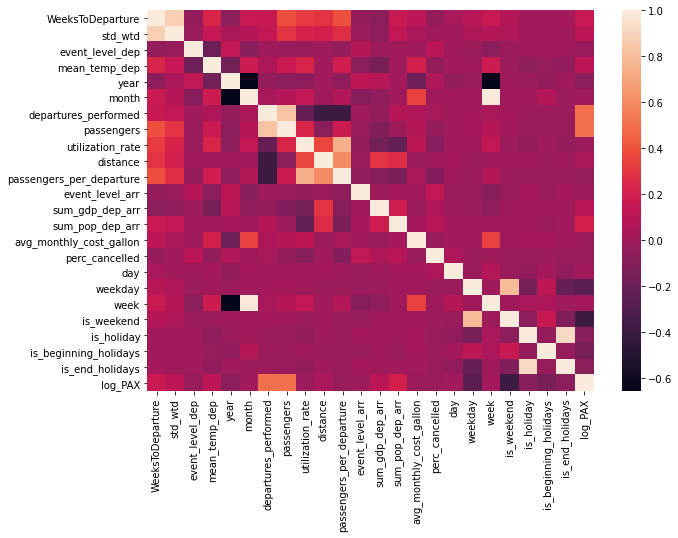

In [13]:
plt.figure(figsize=(10, 7))
correlation = X.corr()
sns.heatmap(correlation)

##### Airport traffic

<AxesSubplot:xlabel='passengers'>

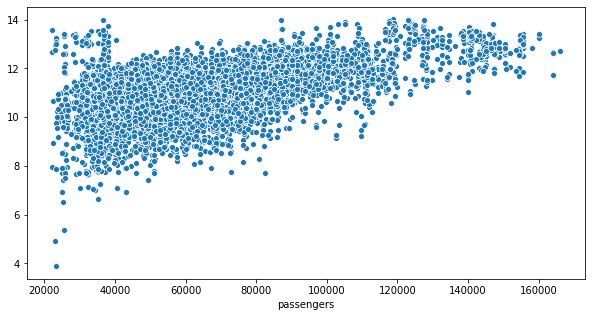

In [14]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='passengers', y=y, data=X)

<AxesSubplot:xlabel='departures_performed'>

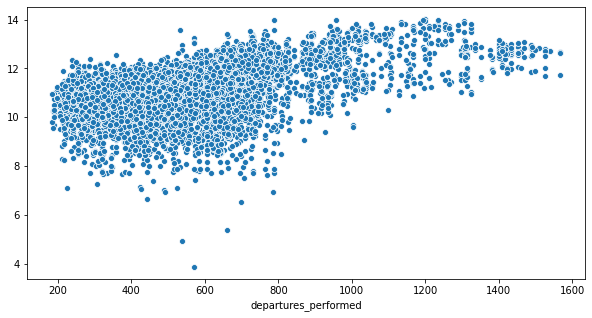

In [15]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='departures_performed', y=y, data=X)

<AxesSubplot:xlabel='passengers_per_departure'>

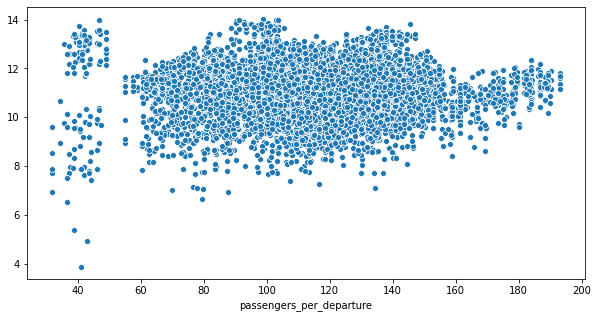

In [16]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='passengers_per_departure', y=y, data=X)

The total number of passengers and departures seem to be sligthly more correlated with the response. However it is not so much the case for the "passengers_per_departure" feature which combines the two. Now let's look at meteorological events and their impact:

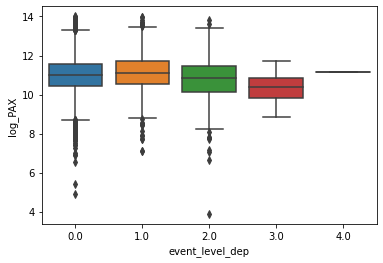

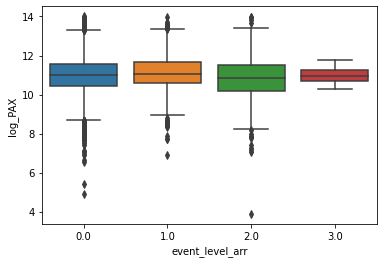

In [17]:
sns.boxplot(x='event_level_dep', y='log_PAX', data=X)
plt.show()
sns.boxplot(x='event_level_arr', y='log_PAX', data=X)
plt.show()

If we create a single column to signal a meteorological event in the Departure or Arrival airport:

<AxesSubplot:xlabel='event_level_dep_arr', ylabel='log_PAX'>

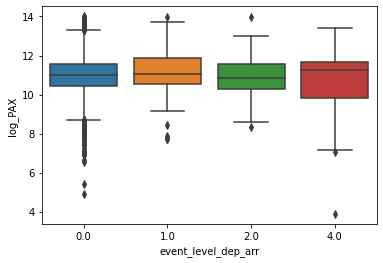

In [18]:
X['event_level_dep_arr'] = X['event_level_dep'] * X['event_level_arr']
sns.boxplot(x='event_level_dep_arr', y='log_PAX', data=X)

It is not really that significant.

<AxesSubplot:xlabel='event_level_dep_arr', ylabel='perc_cancelled'>

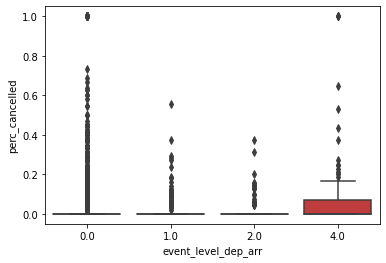

In [19]:
sns.boxplot(x='event_level_dep_arr', y='perc_cancelled', data=X)

We suspect our cancelled flights data is not very good because log_PAX is still relatively high even for flights that were supposed to be entirely cancelled.

<AxesSubplot:xlabel='perc_cancelled'>

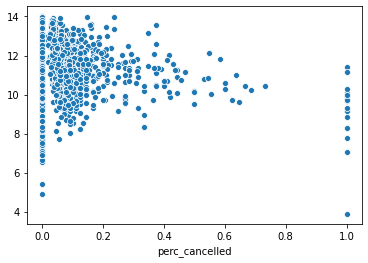

In [20]:
sns.scatterplot(x='perc_cancelled', y=y, data=X)

#### Tickets 

<AxesSubplot:xlabel='WeeksToDeparture'>

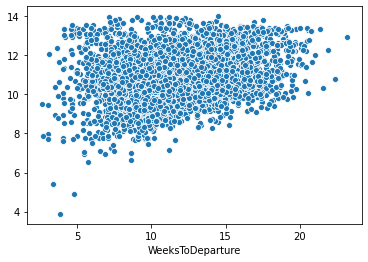

In [21]:
sns.scatterplot(x='WeeksToDeparture', y=y, data=X)

From the scatterplot, we see that when the average time from departure of bookings is larger, log_PAX tends to be larger. It makes sense as longer flights are often booked in advance and generate more demand.

<AxesSubplot:xlabel='distance', ylabel='WeeksToDeparture'>

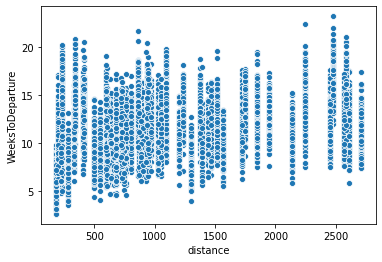

In [22]:
sns.scatterplot(x='distance', y='WeeksToDeparture', data=X)

The plot above does not really confirm this hypothesis. Let's check then which flights are booked the earlier. To do that, we need a "connexion" column that represents an itinerary regardless of the direction of the connexion (ex: LGA-BOS = BOS-LGA). Actually, we also want to test which connexions show huge variations in the number of daily passengers vs those that don't. 

In [23]:
connexions = []
for i in range(len(X)):
    departure, arrival = X['Departure'][i], X['Arrival'][i] 
    if departure <= arrival:
        connexions.append([departure, arrival])
    else:
        connexions.append([arrival, departure])

In [24]:
X['connexion'] = ['_'.join(x) for x in connexions]

In [25]:
connexion_stats = X.groupby('connexion').agg(['min', 'max', 'mean', 'std'])['log_PAX'].reset_index()
connexion_stats['range'] = connexion_stats['max'] - connexion_stats['min']

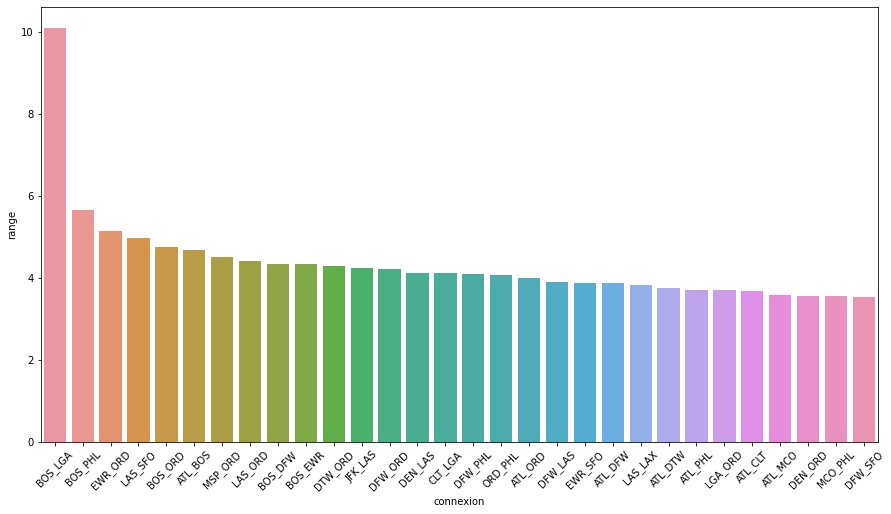

In [26]:
plt.figure(figsize=(15, 8))
sns.barplot(x='connexion',
            y='range',
           data=connexion_stats.sort_values('range', ascending=False)[:30])
plt.xticks(rotation=45)
plt.show()

We see from this plot that the BOS_LGA itinerary shows significant variations in the number of passengers, with a log_PAX that has a range of more than 10!

In [27]:
average_wtd_route = connexion_stats.set_index('connexion')['mean'].to_dict()
X['average_wtd_connexion'] = X['connexion'].replace(average_wtd_route)

<AxesSubplot:xlabel='average_wtd_connexion'>

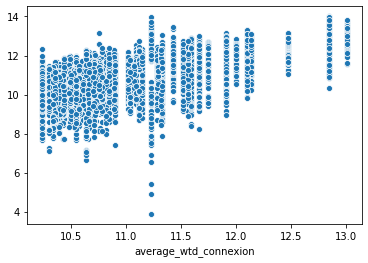

In [28]:
sns.scatterplot(x='average_wtd_connexion', y=y, data=X)

The outliers are BOS-LGA and LGA-BOS again. Let's plot WeeksToDeparture against log_PAX for this specific itinerary:

<AxesSubplot:xlabel='WeeksToDeparture', ylabel='log_PAX'>

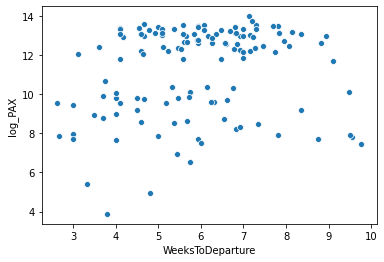

In [29]:
sns.scatterplot(x='WeeksToDeparture', y='log_PAX', data=X[X['connexion'] == 'BOS_LGA'])

<AxesSubplot:xlabel='std_wtd', ylabel='log_PAX'>

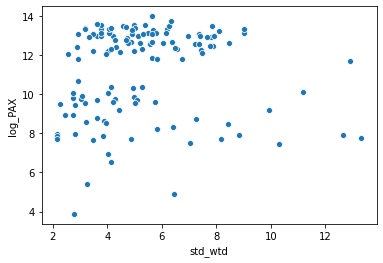

In [30]:
sns.scatterplot(x='std_wtd', y='log_PAX', data=X[X['connexion'] == 'BOS_LGA'])

Weirdly enough, both WTD variables do not seem to have a strong explanatory power here. To identify the issue, we will focus more on this itinerary in the next section.

### Boston to LGA New York City

In [31]:
bl = X[X['connexion'] == 'BOS_LGA']
col = ['WeeksToDeparture',
       'std_wtd', 'mean_temp_dep', 'year', 'month',
       'utilization_rate',
       'passengers_per_departure', 'sum_gdp_dep_arr',
       'perc_cancelled', 'weekday', 'week', 'is_weekend', 'is_holiday', 
              'is_beginning_holidays',
       'is_end_holidays', 'log_PAX', 'event_level_dep_arr']

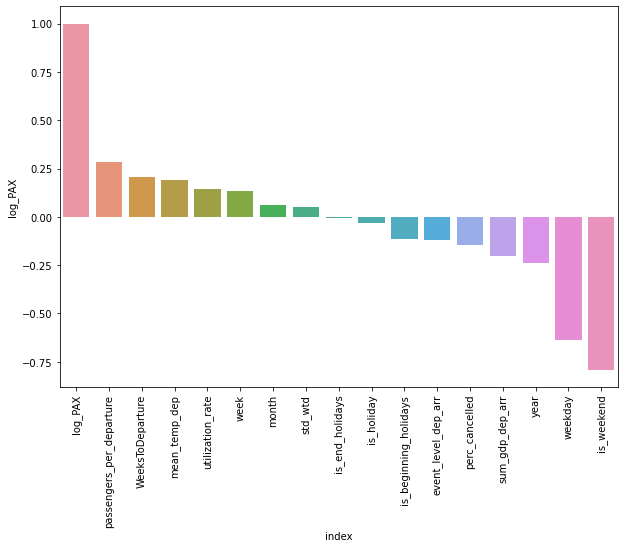

In [32]:
plt.figure(figsize=(10, 7))
correlations = bl[col].corr()['log_PAX'].sort_values(ascending=False).reset_index()
sns.barplot(x=correlations['index'], y=correlations['log_PAX'])
plt.xticks(rotation=90)
plt.show()

Key findings: 
- Keeping just one "passenger" or "departure" variable is enough
- "Day" is useless
- Might be good to separate is_weekend into is_saturday and is_sunday

<AxesSubplot:xlabel='passengers_per_departure', ylabel='log_PAX'>

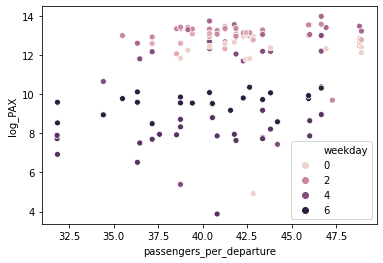

In [33]:
sns.scatterplot(x='passengers_per_departure', y='log_PAX', data=bl, hue='weekday')

Let's look at seasonality in more details...

<AxesSubplot:xlabel='month', ylabel='log_PAX'>

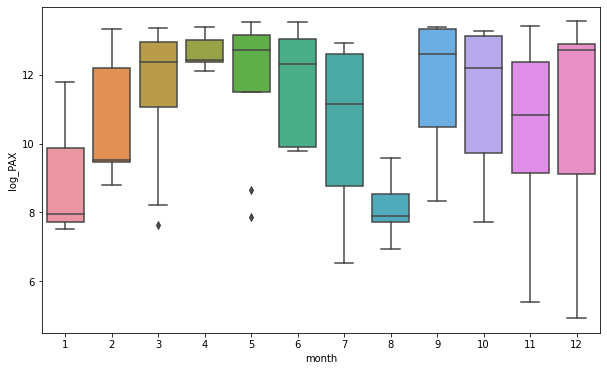

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='log_PAX', data=bl[bl['year'] == 2012])

Key findings: 
- Nobody wants to fly in august, many people want to fly in April!
- The number of daily passengers shows strong variations in July and December!

<AxesSubplot:xlabel='weekday', ylabel='log_PAX'>

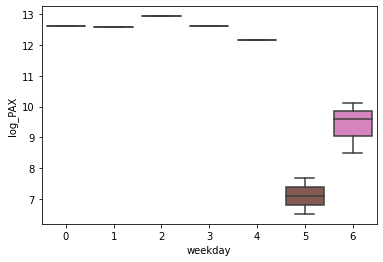

In [35]:
july_2012 = bl[(bl['year'] == 2012) & (bl['month'] == 7)]
sns.boxplot(x='weekday', y='log_PAX', data=july_2012)

Weekday is a significant predictor for log_PAX: absolutely nobody wants to fly on Saturdays! Same for Sundays but less

In [36]:
dec_2012 = bl[(bl['year'] == 2012) & (bl['month'] == 12)]
dec_2012.sort_values('DateOfDeparture')

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,event_level_dep,mean_temp_dep,year,month,departures_performed,...,weekday,week,is_weekend,is_holiday,is_beginning_holidays,is_end_holidays,log_PAX,event_level_dep_arr,connexion,average_wtd_connexion
5982,2012-12-06,LGA,BOS,5.583333,3.752777,0.0,2,2012,12,533.0,...,3,49,False,False,False,False,13.555060,0.0,BOS_LGA,11.227806
253,2012-12-08,LGA,BOS,3.000000,2.828427,0.0,7,2012,12,533.0,...,5,49,True,False,False,False,7.949795,0.0,BOS_LGA,11.227806
521,2012-12-10,BOS,LGA,5.642857,4.199032,0.0,11,2012,12,538.0,...,0,50,False,False,False,False,12.961314,0.0,BOS_LGA,11.227806
3084,2012-12-10,LGA,BOS,5.615385,4.874055,0.0,11,2012,12,533.0,...,0,50,False,False,False,False,12.657063,0.0,BOS_LGA,11.227806
5387,2012-12-18,BOS,LGA,5.916667,4.273775,1.0,8,2012,12,538.0,...,1,51,False,False,False,False,12.769383,1.0,BOS_LGA,11.227806
6035,2012-12-31,BOS,LGA,4.800000,6.457554,0.0,-2,2012,12,538.0,...,0,1,False,False,True,False,4.921778,0.0,BOS_LGA,11.227806


Lower values are explained either by the weekday (Saturday) or an event (NY Eve). 

### Feature selection

In [37]:
X['is_saturday'] = X['weekday'] == 4
X['is_sunday'] = X['weekday'] == 5

In [38]:
all_features = ['Departure', 'Arrival', 'WeeksToDeparture',
       'std_wtd', 'mean_temp_dep', 'year', 'month',
       'departures_performed', 'passengers', 'utilization_rate', 'distance',
       'passengers_per_departure', 'sum_gdp_dep_arr', 'is_saturday', 'is_sunday'
       'sum_pop_dep_arr', 'avg_monthly_cost_gallon', 'perc_cancelled',
       'weekday', 'week', 'is_weekend', 'is_holiday', 'is_beginning_holidays',
       'is_end_holidays', 'event_level_dep_arr', 'connexion']

In [39]:
lgb_model = lgb.LGBMRegressor()
xgb_model = xgb.XGBRegressor()
cat_model = catboost.CatBoostRegressor(silent=True)

In [40]:
features = ['Departure', 'Arrival', 'WeeksToDeparture',
       'mean_temp_dep', 'year', 'month',
       'weekday', 'week']
col_to_encode = ['Departure', 'Arrival']
new_col_encoded = ['dep', 'arr']

X_train = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)

# cross val score
print(-cross_val_score(lgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(xgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(cat_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.18033276478170554
[14:11:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:11:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:11:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.36415759059562686
0.22199344216509168


In [41]:
features = ['connexion', 'WeeksToDeparture',
       'mean_temp_dep', 'year', 'month',
       'weekday', 'week']
col_to_encode = ['connexion']
new_col_encoded = ['conn']

X_train = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)

# cross val score
print(-cross_val_score(lgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(xgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(cat_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.16029418700101394
[14:11:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:11:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:11:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.3333819791364918
0.19926811773305642


In [42]:
features = ['connexion', 'WeeksToDeparture',
       'mean_temp_dep', 'year', 'month',
       'weekday', 'week', 'passengers_per_departure']
col_to_encode = ['connexion']
new_col_encoded = ['conn']

X_train = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)

# cross val score
print(-cross_val_score(lgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(xgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(cat_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.15750050410566396
[14:11:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:11:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:12:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.3266353156549274
0.19408019523784295


In [43]:
features = ['connexion', 'WeeksToDeparture',
       'mean_temp_dep', 'year', 'month',
       'weekday', 'week', 'passengers_per_departure', 'utilization_rate']
col_to_encode = ['connexion']
new_col_encoded = ['conn']

X_train = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)

# cross val score
print(-cross_val_score(lgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(xgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(cat_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.1609511628109614
[14:12:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:12:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:12:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.3304146196921477
0.19972136973950397


In [44]:
features = ['connexion', 'WeeksToDeparture',
       'mean_temp_dep', 'year', 'month',
       'weekday', 'week', 'passengers_per_departure',
           'is_weekend']
col_to_encode = ['connexion']
new_col_encoded = ['conn']

X_train = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)

# cross val score
print(-cross_val_score(lgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(xgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(cat_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.15750050410566396
[14:12:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:12:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:12:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.3266186007327306
0.19564542877035707


In [45]:
features = ['connexion', 'WeeksToDeparture',
       'mean_temp_dep', 'year', 'month',
       'weekday', 'week', 'passengers_per_departure',
           'is_saturday', 'is_sunday']
col_to_encode = ['connexion']
new_col_encoded = ['conn']

X_train = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)

# cross val score
print(-cross_val_score(lgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(xgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(cat_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.16416515719497957
[14:12:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:12:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:12:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.31531944499944525
0.19143593486879484


In [60]:
features = ['connexion', 'WeeksToDeparture',
       'mean_temp_dep', 'year', 'month',
       'weekday', 'week', 'passengers_per_departure',
           'is_saturday', 'is_sunday', 'is_holiday']
col_to_encode = ['connexion']
new_col_encoded = ['conn']

X_train = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)

# cross val score
print(-cross_val_score(lgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(xgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(cat_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.16312935755920896
[14:20:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.31074984650528786
0.1869802359521038


In [61]:
features = ['connexion', 'WeeksToDeparture',
       'mean_temp_dep', 'year', 'month',
       'weekday', 'week', 'passengers_per_departure',
           'is_saturday', 'is_sunday', 'is_holiday',
           'is_beginning_holidays', 'is_end_holidays']
col_to_encode = ['connexion']
new_col_encoded = ['conn']

X_train = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)

# cross val score
print(-cross_val_score(lgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(xgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(cat_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.15885776755190795
[14:20:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.30501977243237294
0.18323528338266448


In [62]:
features = ['connexion', 'WeeksToDeparture',
       'mean_temp_dep', 'year', 'month',
       'weekday', 'week', 'passengers_per_departure',
           'is_saturday', 'is_sunday', 'is_holiday',
           'is_beginning_holidays', 'is_end_holidays',
           'event_level_dep_arr']
col_to_encode = ['connexion']
new_col_encoded = ['conn']

X_train = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)

# cross val score
print(-cross_val_score(lgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(xgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(cat_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.1597348804130877
[14:20:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:20:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.30639578071695145
0.18215585016919988


In [63]:
features = ['connexion', 'WeeksToDeparture',
       'mean_temp_dep', 'year', 'month',
       'weekday', 'week', 'passengers',
            'departures_performed',
           'is_saturday', 'is_sunday', 'is_holiday',
           'is_beginning_holidays', 'is_end_holidays',
           'event_level_dep_arr']
col_to_encode = ['connexion']
new_col_encoded = ['conn']

X_train = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)

# cross val score
print(-cross_val_score(lgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(xgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(cat_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.15469328463052417
[14:20:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.2656731674789163
0.17014153602562834


In [64]:
features = ['connexion', 'WeeksToDeparture',
       'mean_temp_dep', 'year', 'month',
       'weekday', 'week', 'passengers',
            'departures_performed',
           'is_saturday', 'is_sunday', 'is_holiday',
           'is_beginning_holidays', 'is_end_holidays',
           'event_level_dep_arr', 'distance']
col_to_encode = ['connexion']
new_col_encoded = ['conn']

X_train = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)

# cross val score
print(-cross_val_score(lgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(xgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(cat_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.14784941060874138
[14:21:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.24549481934762207
0.16404535954031238


In [65]:
features = ['connexion', 'WeeksToDeparture',
       'mean_temp_dep', 'year', 'month',
       'weekday', 'week', 'passengers',
            'departures_performed',
           'is_saturday', 'is_sunday', 'is_holiday',
           'is_beginning_holidays', 'is_end_holidays',
           'event_level_dep_arr', 'distance',
           'perc_cancelled']
col_to_encode = ['connexion']
new_col_encoded = ['conn']

X_train = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)

# cross val score
print(-cross_val_score(lgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(xgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(cat_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.14693427155053643
[14:21:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.24706285237976192
0.16234458473240468


In [66]:
features = ['connexion', 'WeeksToDeparture',
       'mean_temp_dep', 'year', 'month',
       'weekday', 'week', 'passengers',
            'departures_performed',
           'is_saturday', 'is_sunday', 'is_holiday',
           'is_beginning_holidays', 'is_end_holidays',
           'event_level_dep_arr', 'distance',
           'perc_cancelled', 'sum_gdp_dep_arr']
col_to_encode = ['connexion']
new_col_encoded = ['conn']

X_train = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)

# cross val score
print(-cross_val_score(lgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(xgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(cat_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.1422631423657576
[14:21:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.23799986728004352
0.16211230534583485


In [67]:
features = ['connexion', 'WeeksToDeparture',
       'mean_temp_dep', 'year', 'month',
       'weekday', 'week', 'passengers',
            'departures_performed',
           'is_saturday', 'is_sunday', 'is_holiday',
           'is_beginning_holidays', 'is_end_holidays',
           'event_level_dep_arr', 'distance',
           'perc_cancelled', 'sum_gdp_dep_arr',
           'sum_pop_dep_arr']
col_to_encode = ['connexion']
new_col_encoded = ['conn']

X_train = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)

# cross val score
print(-cross_val_score(lgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(xgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(cat_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.14188110987077537
[14:22:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.2239572389606704
0.15760532568702815


In [68]:
features = ['connexion', 'WeeksToDeparture',
       'mean_temp_dep', 'year', 'month',
       'weekday', 'week', 'passengers',
            'departures_performed',
           'is_saturday', 'is_sunday', 'is_holiday',
           'is_beginning_holidays', 'is_end_holidays',
           'event_level_dep_arr', 'distance',
           'perc_cancelled', 'sum_gdp_dep_arr',
           'sum_pop_dep_arr', 'avg_monthly_cost_gallon']
col_to_encode = ['connexion']
new_col_encoded = ['conn']

X_train = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)

# cross val score
print(-cross_val_score(lgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(xgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(cat_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.1412448769699464
[14:22:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.22314014915142807
0.15669951499384627


### Final model and features

In [69]:
features = ['connexion', 'WeeksToDeparture',
       'mean_temp_dep', 'year', 'month',
       'weekday', 'week', 'passengers',
            'departures_performed',
           'is_saturday', 'is_sunday', 'is_holiday',
           'is_beginning_holidays', 'is_end_holidays',
           'event_level_dep_arr', 'distance',
           'perc_cancelled', 'sum_gdp_dep_arr',
           'sum_pop_dep_arr']
col_to_encode = ['connexion']
new_col_encoded = ['conn']

X_train = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)

# cross val score
print(-cross_val_score(lgb_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())
print(-cross_val_score(cat_model, X_train, y, cv=3, scoring='neg_mean_squared_error').mean())

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.14188110987077537
[0.14374974 0.16673184 0.1623344 ]


We test the model on a train vs validation set.

In [72]:
X_train_full = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)
y_train_full = y

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [73]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.8, random_state=42)

In [74]:
# fit the data
cat_model.fit(X_train, y_train)

# print score
print('Train error:', mean_squared_error(cat_model.predict(X_train), y_train))
print('Validation error:', mean_squared_error(cat_model.predict(X_valid), y_valid))

Train error: 0.12831742278295122
Validation error: 0.1467302942216578


In [75]:
# fit the data
lgb_model.fit(X_train, y_train)

# print score
print('Train error:', mean_squared_error(lgb_model.predict(X_train), y_train))
print('Validation error:', mean_squared_error(lgb_model.predict(X_valid), y_valid))

Train error: 0.08908864237344374
Validation error: 0.12911816930626915


Our model is obviously overfitting here.

In [89]:
#!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer

     |████████████████████████████████| 101 kB 3.2 MB/s ta 0:00:011
ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/opt/anaconda3/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "/opt/anaconda3/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call 

In [90]:
search_spaces = {'iterations': Integer(10, 1000),
                 'depth': Integer(1, 8),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'l2_leaf_reg': Integer(2, 30)}

In [91]:
# Setting up BayesSearchCV
from sklearn.metrics import make_scorer

clf = catboost.CatBoostRegressor(loss_function='RMSE',
                         verbose= False
                        )
opt = BayesSearchCV(clf,
                    search_spaces,
                    scoring=make_scorer(mean_squared_error),
                    n_iter=10,
                    return_train_score=True,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)

In [92]:
opt.fit(X_train, y_train)

BayesSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7fe90b1e3d90>,
              n_iter=10, optimizer_kwargs={'base_estimator': 'GP'},
              random_state=42, return_train_score=True,
              scoring=make_scorer(mean_squared_error),
              search_spaces={'bagging_temperature': Real(low=0.0, high=1.0, prior='uniform', transform='identity'),
                             'depth': Integer(low=1, high=8, prior='uniform', transform='identity'),
                             'iterations': Integer(low=10, high=1000, prior='uniform', transform='identity'),
                             'l2_leaf_reg': Integer(low=2, high=30, prior='uniform', transform='identity'),
                             'learning_rate': Real(low=0.01, high=1.0, prior='log-uniform', transform='identity'),
                             'random_strength': Real(low=1e-09, high=10, prior='log-uniform', transform='identity')})

In [93]:
opt.best_params_

OrderedDict([('bagging_temperature', 0.44483251230115184),
             ('depth', 7),
             ('iterations', 114),
             ('l2_leaf_reg', 14),
             ('learning_rate', 0.023763498182367167),
             ('random_strength', 3.440752531396279e-05)])

In [94]:
# fit the data
cat_model_tuned = catboost.CatBoostRegressor(eval_metric= 'RMSE',
 iterations= 600,
 l2_leaf_reg= 20,
 random_strength= 1,
 rsm= 1,
 boost_from_average= True,
 model_size_reg= 0.5,
 subsample= 0.8,
 use_best_model= False,
 random_seed= 42,
 depth= 6,
 posterior_sampling= False,
 border_count= 254,
 sparse_features_conflict_fraction= 0,
 leaf_estimation_backtracking= 'AnyImprovement',
 best_model_min_trees= 1,
 model_shrink_rate= 0,
 min_data_in_leaf= 1,
 loss_function= 'RMSE',
 learning_rate= 0.117,
 score_function= 'Cosine',
 task_type= 'CPU',
 leaf_estimation_iterations= 1,
 bootstrap_type= 'MVS',
verbose=False)
cat_model_tuned.fit(X_train, y_train)

# print score
print('Train error:', mean_squared_error(cat_model_tuned.predict(X_train), y_train))
print('Validation error:', mean_squared_error(cat_model_tuned.predict(X_valid), y_valid))

TypeError: __init__() got an unexpected keyword argument 'boost_from_average'

In [ ]:
cross_val_score(cat_model_tuned, X_train_full, y_train_full, scoring='neg_mean_squared_error').mean()

### Which flights are poorly estimated ? 

In [95]:
predictions = cross_val_predict(lgb_model, X_train_full, y_train_full)

In [96]:
import warnings
warnings.filterwarnings('ignore')
X_pred = X
X_pred.loc[:, 'log_PAX'] = y
X_pred.loc[:, 'prediction'] = predictions
X_pred.loc[:, 'error'] = (X_pred.loc[:, 'log_PAX'] - X_pred.loc[:, 'prediction'])**2

7% of the dataset generates more than 50% of the mean squared error.

In [97]:
top_7_pct = int(len(X_pred) * 0.07)
X_errors = X_pred.sort_values('error', ascending=False).iloc[:623, :]

In [98]:
X_errors.connexion.value_counts(normalize=True, ascending=False).head()

BOS_LGA    0.051364
LAS_SFO    0.035313
JFK_LAS    0.035313
ATL_MCO    0.033708
DFW_LAS    0.030498
Name: connexion, dtype: float64

Some connexions generate more errors than others. Let's check in terms of error size:

In [99]:
(X_errors.groupby('connexion').agg('sum')['error'].sort_values(ascending=False) / X_errors['error'].sum()).head()

connexion
BOS_LGA    0.182553
LAS_SFO    0.047289
JFK_LAS    0.036587
ATL_MCO    0.032354
BOS_PHL    0.030918
Name: error, dtype: float64

Boston/LGA is generating most of the error as we notice during EDA. 

### Analysis of errors 

<AxesSubplot:>

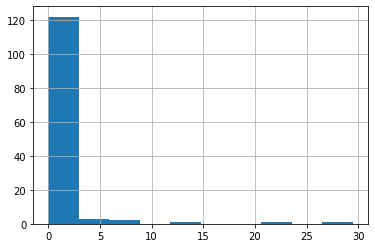

In [100]:
bl = X_pred.reset_index(drop=True)[X_pred['connexion'] == 'BOS_LGA']
bl['error'].hist()

In [101]:
bl[bl['error'] > 10]

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,event_level_dep,mean_temp_dep,year,month,departures_performed,...,is_beginning_holidays,is_end_holidays,log_PAX,event_level_dep_arr,connexion,average_wtd_connexion,is_saturday,is_sunday,prediction,error
1903,2012-11-23,LGA,BOS,3.333333,3.265986,0.0,6,2012,11,659.0,...,False,False,5.390473,0.0,BOS_LGA,11.227806,True,False,10.819942,29.479133
6035,2012-12-31,BOS,LGA,4.800000,6.457554,0.0,-2,2012,12,538.0,...,True,False,4.921778,0.0,BOS_LGA,11.227806,False,False,9.611405,21.992605
6486,2013-02-09,LGA,BOS,3.800000,2.774887,2.0,-2,2013,2,571.0,...,False,False,3.878108,4.0,BOS_LGA,11.227806,False,True,7.513000,13.212443


In [102]:
X_filtered = X[~((X['DateOfDeparture'] == '2012-12-31') & (X['connexion'] == 'BOS_LGA'))]
X_train_filtered = _dummify_data(X_filtered[features], col=col_to_encode, new_col=new_col_encoded)
y_train_filtered = X_filtered['log_PAX']

### To conclude, test full model with stacked regressors

In [113]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, colsample_bytree=0.82, gamma=0.19,
                             learning_rate=0.26, max_depth=5, n_estimators=122, subsample=0.97)

lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42, metric="rmse", learning_rate=0.38,
                                 max_depth=29, n_estimators=320, num_leaves=116, reg_alpha=0.79)

hist_model = HistGradientBoostingRegressor(learning_rate=0.38, l2_regularization=0.198)

estimators = [('cat', cat_model), ('lgb', lgb_model), ('hist', hist_model)]

stacked_model = StackingRegressor(estimators=estimators,
                                  final_estimator=LassoLarsCV(normalize=True)
                                  )

In [114]:
X_train_full = _dummify_data(X[features], col=col_to_encode, new_col=new_col_encoded)
y_train_full = y

In [105]:
'''
params = {
    'lgbmregressor__learning_rate': uniform(0.01, 1.0),
    'lgbmregressor__num_leaves': randint(10, 200),
    'lgbmregressor__n_estimators': randint(50, 500),
    'lgbmregressor__max_depth': randint(1, 50),
    'lgbmregressor__reg_alpha':  uniform(0.01, 1.0)
}

search = RandomizedSearchCV(lgb_model, param_distributions=params, random_state=42, scoring='neg_root_mean_squared_error',
                            n_iter=300, cv=5, verbose=1, n_jobs=-1, return_train_score=True)

search.fit(X_train_full, y_train_full)

search.best_params_
'''

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  3.1min finished


{'lgbmregressor__learning_rate': 0.3845401188473625,
 'lgbmregressor__max_depth': 29,
 'lgbmregressor__n_estimators': 320,
 'lgbmregressor__num_leaves': 116,
 'lgbmregressor__reg_alpha': 0.7896910002727693}

In [119]:
cross_val_score(stacked_model, X_train_full, y_train_full, cv=3, scoring='neg_mean_squared_error')


array([nan, nan, nan])

In [120]:
mse

nan